# 🗺️ LIDAR Mapping & Grasp v15

## ✨ Features
| Feature | Description |
|---------|-------------|
| **📍 Height Map** | สแกนพื้นที่สร้างแผนที่ความสูง |
| **🎨 Visualization** | แสดง Heatmap สี |
| **🎯 Object Detection** | หาวัตถุจาก height difference |
| **📏 Precise Height** | รู้ความสูงแม่นยำจาก map |

## 📐 Specifications
- **Work Area:** 170 x 150 mm (17 x 15 cm)
- **Resolution:** 10 mm (finest practical)
- **Grid Points:** 17 x 15 = 255 points
- **Scan Time:** ~2-3 minutes

## 1️⃣ Imports

In [1]:
import cv2
import numpy as np
import time
import socket
import serial
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import ndimage

print("✓ Imports (v15 - LIDAR Mapping)")

✓ Imports (v15 - LIDAR Mapping)


## 2️⃣ Hardware Configuration

In [2]:
ROBOT_IP = '192.168.1.6'
ESP32_PORT = 'COM9'
ESP32_BAUDRATE = 115200
CAMERA_ID = 2

HOMOGRAPHY_MATRIX = np.load('homography_matrix.npy')

print("✓ Hardware config")

✓ Hardware config


## 3️⃣ Configuration

In [3]:
# === CALIBRATED VALUES ===
PIXELS_PER_MM = 2.7703
ROBOT_R_OFFSET = -25.55

# === Z Heights ===
Z_FLOOR = -64
Z_SCAN = 120  # ความสูงที่ใช้สแกน (ต้องสูงพอให้ LIDAR ทำงานได้)

# === v15: LIDAR Mapping ===
# พื้นที่สแกน (Robot coordinates) - ปรับตามตำแหน่งจริง ปรับทีหลังอยู่ดีเฮีย
SCAN_X_START = 250   # mm
SCAN_X_END = 420     # mm (250 + 170)
SCAN_Y_START = 50    # mm
SCAN_Y_END = 200     # mm (50 + 150)

# Resolution (ละเอียดสุด = 5mm, แนะนำ = 10mm)
SCAN_RESOLUTION = 10  # mm

# Object detection threshold
HEIGHT_THRESHOLD = 10  # mm (ถ้าสูงกว่าพื้น 10mm = วัตถุ)

# === LIDAR XY Offset ===
LIDAR_X_OFFSET = 25.08
LIDAR_Y_OFFSET = 20.71

# === Drop Position ===
DROP_POS = (169.71, 58.01, -17.07, 13.78)

# === Gripper ===
GRIPPER_MAX_WIDTH_MM = 54
GRIPPER_OPEN_MARGIN_MM = 5
GRIPPER_GRIP_MARGIN_MM = 5

# Calculate grid size
GRID_X = int((SCAN_X_END - SCAN_X_START) / SCAN_RESOLUTION) + 1
GRID_Y = int((SCAN_Y_END - SCAN_Y_START) / SCAN_RESOLUTION) + 1
TOTAL_POINTS = GRID_X * GRID_Y

print("✓ Configuration v15")
print(f"   Scan area: {SCAN_X_END-SCAN_X_START} x {SCAN_Y_END-SCAN_Y_START} mm")
print(f"   Resolution: {SCAN_RESOLUTION} mm")
print(f"   Grid: {GRID_X} x {GRID_Y} = {TOTAL_POINTS} points")
print(f"   Estimated time: ~{TOTAL_POINTS * 0.5 / 60:.1f} minutes")

✓ Configuration v15
   Scan area: 170 x 150 mm
   Resolution: 10 mm
   Grid: 18 x 16 = 288 points
   Estimated time: ~2.4 minutes


## 4️⃣ SmartGripperController Class

In [4]:
class SmartGripperController:
    CALIB_ANGLES = np.array([22, 30, 40, 50, 60, 70, 80, 90, 96])
    CALIB_WIDTHS = np.array([54.0, 52.0, 48.0, 40.0, 32.0, 23.0, 12.0, 3.0, 0.0])
    
    def __init__(self, port='COM9', baudrate=115200):
        self.port = port
        self.baudrate = baudrate
        self.serial = None
        self.target_width = None
        
    def connect(self):
        try:
            self.serial = serial.Serial(self.port, self.baudrate, timeout=2)
            time.sleep(2)
            self.serial.reset_input_buffer()
            print(f"✅ Gripper+LIDAR on {self.port}")
            return True
        except Exception as e:
            print(f"❌ {e}")
            return False
    
    def disconnect(self):
        if self.serial: 
            self.serial.close()
            self.serial = None
    
    def send_command(self, cmd):
        if self.serial and self.serial.is_open:
            self.serial.reset_input_buffer()
            self.serial.write((cmd + '\n').encode())
            time.sleep(0.3)
    
    def mm_to_angle(self, width_mm):
        width = max(0.0, min(54.0, width_mm))
        return int(round(np.interp(width, self.CALIB_WIDTHS[::-1], self.CALIB_ANGLES[::-1])))
    
    def open_fully(self):
        self.send_command('G22')
    
    def grip_object(self, width_mm):
        grip_w = max(0.0, width_mm - GRIPPER_GRIP_MARGIN_MM)
        angle = self.mm_to_angle(grip_w)
        self.send_command(f'G{angle}')
    
    def release(self):
        open_w = min(54.0, (self.target_width or 30) + 10)
        self.send_command(f'G{self.mm_to_angle(open_w)}')
        self.target_width = None
    
    def read_lidar(self, samples=3):
        if not self.serial or not self.serial.is_open:
            return None
        
        readings = []
        for _ in range(samples):
            self.serial.reset_input_buffer()
            self.serial.write(b'L\n')
            
            start = time.time()
            while time.time() - start < 1.0:
                if self.serial.in_waiting > 0:
                    response = self.serial.readline().decode().strip()
                    if response.startswith("LIDAR:") and "ERR" not in response:
                        try:
                            dist = int(response.split(":")[1])
                            readings.append(dist)
                        except:
                            pass
                        break
            time.sleep(0.02)
        
        if readings:
            return int(np.median(readings))
        return None

print("✓ SmartGripperController")

✓ SmartGripperController


## 5️⃣ DobotControllerTCP Class

In [5]:
class DobotControllerTCP:
    def __init__(self, homography_matrix=None, r_offset=-25.55):
        self.dashboard_port = 29999
        self.sock = None
        self.H = homography_matrix
        self.r_offset = r_offset
        
    def connect(self, ip):
        try:
            self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            self.sock.settimeout(5)
            self.sock.connect((ip, self.dashboard_port))
            self.send_command("ClearError()")
            time.sleep(0.5)
            self.send_command("EnableRobot()")
            time.sleep(4)
            self.send_command("User(1)")
            self.send_command("Tool(1)")
            self.send_command("SpeedFactor(80)")  # Faster for scanning
            print("✅ Robot connected!")
            return True
        except Exception as e:
            print(f"Error: {e}")
            return False

    def send_command(self, cmd):
        if self.sock:
            self.sock.send((cmd + "\n").encode("utf-8"))
            return self.sock.recv(1024).decode("utf-8")

    def home(self):
        print("🤖 HOME...")
        self.send_command("MovJ(-253.07, 115.17, -17.07, -62.78)")
        time.sleep(4)

    def move_to(self, x, y, z, r=0):
        cmd = f"MovJ({x},{y},{z},{r})"
        return self.send_command(cmd)
    
    def move_to_and_wait(self, x, y, z, r=0, wait=1):
        self.move_to(x, y, z, r)
        time.sleep(wait)
    
    def joint_move(self, j1=0, j2=0, j3=0, j4=0):
        cmd = f"JointMovJ({j1},{j2},{j3},{j4})"
        return self.send_command(cmd)
    
    def joint_move_and_wait(self, j1=0, j2=0, j3=0, j4=0, wait=3):
        self.joint_move(j1, j2, j3, j4)
        time.sleep(wait)

    def pixel_to_robot(self, u, v):
        if self.H is None: return None, None
        pt = np.array([u, v, 1], dtype=np.float32)
        res = np.dot(self.H, pt)
        return res[0]/res[2], res[1]/res[2]
    
    def camera_angle_to_robot_r(self, camera_angle):
        return self.r_offset - camera_angle

print("✓ DobotControllerTCP")

✓ DobotControllerTCP


## 6️⃣ LidarMapper Class (NEW!)

In [14]:
class LidarMapper:
    """v15: LIDAR Height Mapping System"""
    
    def __init__(self, robot, gripper):
        self.robot = robot
        self.gripper = gripper
        self.height_map = None
        self.distance_map = None
        self.floor_distance = None  # Distance from LIDAR to floor at Z_SCAN
        
    def calibrate_floor(self):
        """Measure floor distance for height calculation"""
        print("📏 Calibrating floor level...")
        
        # Move to a known empty spot
        x_mid = (SCAN_X_START + SCAN_X_END) / 2
        y_mid = (SCAN_Y_START + SCAN_Y_END) / 2
        
        self.robot.move_to_and_wait(x_mid, y_mid, Z_SCAN, ROBOT_R_OFFSET, 2)
        
        # Read floor distance
        self.floor_distance = self.gripper.read_lidar(samples=10)
        print(f"📏 Floor distance at Z={Z_SCAN}: {self.floor_distance} mm")
        
        return self.floor_distance
    
    def scan(self, show_progress=True):
        """Scan the work area and create height map"""
        print(f"\n🗺️ Starting LIDAR scan...")
        print(f"   Area: {SCAN_X_START}-{SCAN_X_END} x {SCAN_Y_START}-{SCAN_Y_END} mm")
        print(f"   Grid: {GRID_X} x {GRID_Y} = {TOTAL_POINTS} points")
        
        # Initialize maps
        self.distance_map = np.zeros((GRID_Y, GRID_X))
        self.height_map = np.zeros((GRID_Y, GRID_X))
        
        # Calibrate floor first
        if self.floor_distance is None:
            self.calibrate_floor()
        
        start_time = time.time()
        point_count = 0
        
        # Scan in zigzag pattern for efficiency
        for iy, y in enumerate(range(int(SCAN_Y_START), int(SCAN_Y_END) + 1, SCAN_RESOLUTION)):
            # Alternate direction for faster scanning
            if iy % 2 == 0:
                x_range = range(int(SCAN_X_START), int(SCAN_X_END) + 1, SCAN_RESOLUTION)
            else:
                x_range = range(int(SCAN_X_END), int(SCAN_X_START) - 1, -SCAN_RESOLUTION)
            for x in x_range:
                ix = int((x - SCAN_X_START) // SCAN_RESOLUTION)
                
                # Move LIDAR to position
                lidar_x = x + LIDAR_X_OFFSET
                lidar_y = y + LIDAR_Y_OFFSET
                self.robot.move_to(lidar_x, lidar_y, Z_SCAN, ROBOT_R_OFFSET)
                time.sleep(0.3)  # Short wait for movement
                
                # Read LIDAR
                dist = self.gripper.read_lidar(samples=3)
                if dist is None:
                    dist = self.floor_distance  # Use floor if error
                
                # Store distance
                self.distance_map[iy, ix] = dist
                
                # Calculate height from floor
                height = self.floor_distance - dist
                self.height_map[iy, ix] = max(0, height)  # No negative heights
                
                point_count += 1
                
                if show_progress and point_count % 10 == 0:
                    elapsed = time.time() - start_time
                    eta = (elapsed / point_count) * (TOTAL_POINTS - point_count)
                    print(f"   Scanning: {point_count}/{TOTAL_POINTS} ({100*point_count/TOTAL_POINTS:.0f}%) ETA: {eta:.0f}s", end='\r')
        
        elapsed = time.time() - start_time
        print(f"\n✅ Scan complete! {TOTAL_POINTS} points in {elapsed:.1f}s")
        
        return self.height_map
    
    def visualize(self, show_objects=True):
        """Visualize the height map"""
        if self.height_map is None:
            print("❌ No map data. Run scan() first.")
            return
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # 1. Height Map (Heatmap)
        im1 = axes[0].imshow(self.height_map, cmap='jet', origin='lower',
                             extent=[SCAN_X_START, SCAN_X_END, SCAN_Y_START, SCAN_Y_END])
        axes[0].set_title('Height Map (mm from floor)')
        axes[0].set_xlabel('X (mm)')
        axes[0].set_ylabel('Y (mm)')
        plt.colorbar(im1, ax=axes[0], label='Height (mm)')
        
        # 2. Distance Map (LIDAR raw)
        im2 = axes[1].imshow(self.distance_map, cmap='viridis', origin='lower',
                             extent=[SCAN_X_START, SCAN_X_END, SCAN_Y_START, SCAN_Y_END])
        axes[1].set_title('LIDAR Distance (mm from sensor)')
        axes[1].set_xlabel('X (mm)')
        axes[1].set_ylabel('Y (mm)')
        plt.colorbar(im2, ax=axes[1], label='Distance (mm)')
        
        # 3. Object Detection
        object_mask = self.height_map > HEIGHT_THRESHOLD
        im3 = axes[2].imshow(object_mask, cmap='RdYlGn', origin='lower',
                             extent=[SCAN_X_START, SCAN_X_END, SCAN_Y_START, SCAN_Y_END])
        axes[2].set_title(f'Objects (height > {HEIGHT_THRESHOLD}mm)')
        axes[2].set_xlabel('X (mm)')
        axes[2].set_ylabel('Y (mm)')
        
        # Find and mark object centers
        if show_objects:
            objects = self.find_objects()
            for obj in objects:
                axes[2].plot(obj['center_x'], obj['center_y'], 'bo', markersize=10)
                axes[2].annotate(f"{obj['height']:.0f}mm", 
                                (obj['center_x'], obj['center_y']),
                                textcoords="offset points", xytext=(5, 5),
                                fontsize=10, color='blue')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def find_objects(self, min_area=2):
        """Find objects from height map"""
        if self.height_map is None:
            return []
        
        # Binary threshold
        binary = (self.height_map > HEIGHT_THRESHOLD).astype(np.uint8)
        
        # Label connected components
        labeled, num_features = ndimage.label(binary)
        
        objects = []
        for i in range(1, num_features + 1):
            # Get object mask
            mask = labeled == i
            area = np.sum(mask)
            
            if area < min_area:
                continue
            
            # Find center (in grid coordinates)
            iy, ix = np.where(mask)
            center_ix = np.mean(ix)
            center_iy = np.mean(iy)
            
            # Convert to robot coordinates
            center_x = SCAN_X_START + center_ix * SCAN_RESOLUTION
            center_y = SCAN_Y_START + center_iy * SCAN_RESOLUTION
            
            # Get height at peak
            peak_height = np.max(self.height_map[mask])
            
            # Get height at center
            center_height = self.height_map[int(center_iy), int(center_ix)]
            
            objects.append({
                'id': i,
                'center_x': center_x,
                'center_y': center_y,
                'center_ix': int(center_ix),
                'center_iy': int(center_iy),
                'height': peak_height,
                'area': area,
            })
        
        # Sort by area (largest first)
        objects = sorted(objects, key=lambda o: o['area'], reverse=True)
        
        print(f"\n🎯 Found {len(objects)} objects:")
        for obj in objects:
            print(f"   Object {obj['id']}: ({obj['center_x']:.0f}, {obj['center_y']:.0f}) H={obj['height']:.0f}mm")
        
        return objects
    
    def get_height_at(self, x, y):
        """Get height at specific robot coordinates"""
        if self.height_map is None:
            return None
        
        ix = int((x - SCAN_X_START) / SCAN_RESOLUTION)
        iy = int((y - SCAN_Y_START) / SCAN_RESOLUTION)
        
        if 0 <= ix < GRID_X and 0 <= iy < GRID_Y:
            return self.height_map[iy, ix]
        return None

print("✓ LidarMapper class")

✓ LidarMapper class


## 7️⃣ Initialize Components

In [15]:
gripper = SmartGripperController(port=ESP32_PORT, baudrate=ESP32_BAUDRATE)
robot = DobotControllerTCP(homography_matrix=HOMOGRAPHY_MATRIX, r_offset=ROBOT_R_OFFSET)
mapper = LidarMapper(robot, gripper)

print("✓ Components initialized (v15)")

✓ Components initialized (v15)


---
# 🤖 CONNECT ROBOT & GRIPPER
---

In [17]:
print("="*60)
print("🤖 Connecting to Robot and Gripper+LIDAR...")
print("="*60)

gripper.connect()
robot.connect(ROBOT_IP)
robot.home()

print("✅ Ready!")

🤖 Connecting to Robot and Gripper+LIDAR...
✅ Gripper+LIDAR on COM9
✅ Robot connected!
🤖 HOME...
✅ Ready!


---
# 🗺️ LIDAR MAPPING
---

In [18]:
# Draw rectangle to define scan area
import cv2

scan_rect = None
drawing = False
start_point = None

def mouse_draw(event, x, y, flags, param):
    global scan_rect, drawing, start_point
    
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_point = (x, y)
    
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            scan_rect = (start_point[0], start_point[1], x, y)
    
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        scan_rect = (start_point[0], start_point[1], x, y)
        print(f"📐 Selected: ({scan_rect[0]}, {scan_rect[1]}) to ({scan_rect[2]}, {scan_rect[3]})")

cap = cv2.VideoCapture(CAMERA_ID)
cv2.namedWindow('Draw Scan Area')
cv2.setMouseCallback('Draw Scan Area', mouse_draw)

print("="*60)
print("🎨 DRAW SCAN AREA")
print("   Click and drag to draw rectangle")
print("   Press ENTER to confirm")
print("   Press Q to cancel")
print("="*60)

confirmed = False

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    
    display = frame.copy()
    
    # Draw current rectangle
    if scan_rect:
        x1, y1, x2, y2 = scan_rect
        cv2.rectangle(display, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Show size (in pixels)
        w = abs(x2 - x1)
        h = abs(y2 - y1)
        cv2.putText(display, f"{w} x {h} px", (min(x1, x2), min(y1, y2) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Instructions
    cv2.rectangle(display, (0, 0), (640, 40), (30, 30, 30), -1)
    cv2.putText(display, "Draw rectangle | ENTER=Confirm | Q=Cancel",
               (10, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    cv2.imshow('Draw Scan Area', display)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == 13 and scan_rect:  # ENTER
        confirmed = True
        break

cap.release()
cv2.destroyAllWindows()

# Convert pixel to robot coordinates
if confirmed and scan_rect:
    x1, y1, x2, y2 = scan_rect
    
    # Get corners in robot coordinates
    rx1, ry1 = robot.pixel_to_robot(min(x1, x2), min(y1, y2))
    rx2, ry2 = robot.pixel_to_robot(max(x1, x2), max(y1, y2))
    
    # Update scan parameters
    SCAN_X_START = min(rx1, rx2)
    SCAN_X_END = max(rx1, rx2)
    SCAN_Y_START = min(ry1, ry2)
    SCAN_Y_END = max(ry1, ry2)
    
    # Recalculate grid
    GRID_X = int((SCAN_X_END - SCAN_X_START) / SCAN_RESOLUTION) + 1
    GRID_Y = int((SCAN_Y_END - SCAN_Y_START) / SCAN_RESOLUTION) + 1
    TOTAL_POINTS = GRID_X * GRID_Y
    
    print(f"\n✅ Scan area updated:")
    print(f"   Pixel: ({x1}, {y1}) to ({x2}, {y2})")
    print(f"   Robot: X={SCAN_X_START:.0f}-{SCAN_X_END:.0f}, Y={SCAN_Y_START:.0f}-{SCAN_Y_END:.0f}")
    print(f"   Size: {SCAN_X_END-SCAN_X_START:.0f} x {SCAN_Y_END-SCAN_Y_START:.0f} mm")
    print(f"   Grid: {GRID_X} x {GRID_Y} = {TOTAL_POINTS} points")
    print(f"   Estimated time: ~{TOTAL_POINTS * 0.5 / 60:.1f} minutes")
else:
    print("❌ Cancelled or no selection")

🎨 DRAW SCAN AREA
   Click and drag to draw rectangle
   Press ENTER to confirm
   Press Q to cancel
📐 Selected: (113, 106) to (360, 439)

✅ Scan area updated:
   Pixel: (113, 106) to (360, 439)
   Robot: X=-45-54, Y=33-128
   Size: 99 x 95 mm
   Grid: 10 x 10 = 100 points
   Estimated time: ~0.8 minutes


In [19]:
# Calibrate floor level first (move objects away!)
print("⚠️ Please clear the work area for floor calibration!")
input("Press ENTER when ready...")

mapper.calibrate_floor()

⚠️ Please clear the work area for floor calibration!
📏 Calibrating floor level...
📏 Floor distance at Z=120: 220 mm


220

In [64]:
# Place objects and scan
print("⚠️ Place objects on the work area now!")
input("Press ENTER to start scanning...")

# Scan!
height_map = mapper.scan(show_progress=True)

# Go home after scanning
robot.home()

⚠️ Place objects on the work area now!

🗺️ Starting LIDAR scan...
   Area: -44.83720133548175-54.25809708268675 x 32.80486088976581-128.0258631896381 mm
   Grid: 10 x 10 = 100 points
   Scanning: 100/100 (100%) ETA: 0s
✅ Scan complete! 100 points in 42.3s
🤖 HOME...



🎯 Found 2 objects:
   Object 2: (26, 54) H=70mm
   Object 3: (-15, 113) H=30mm


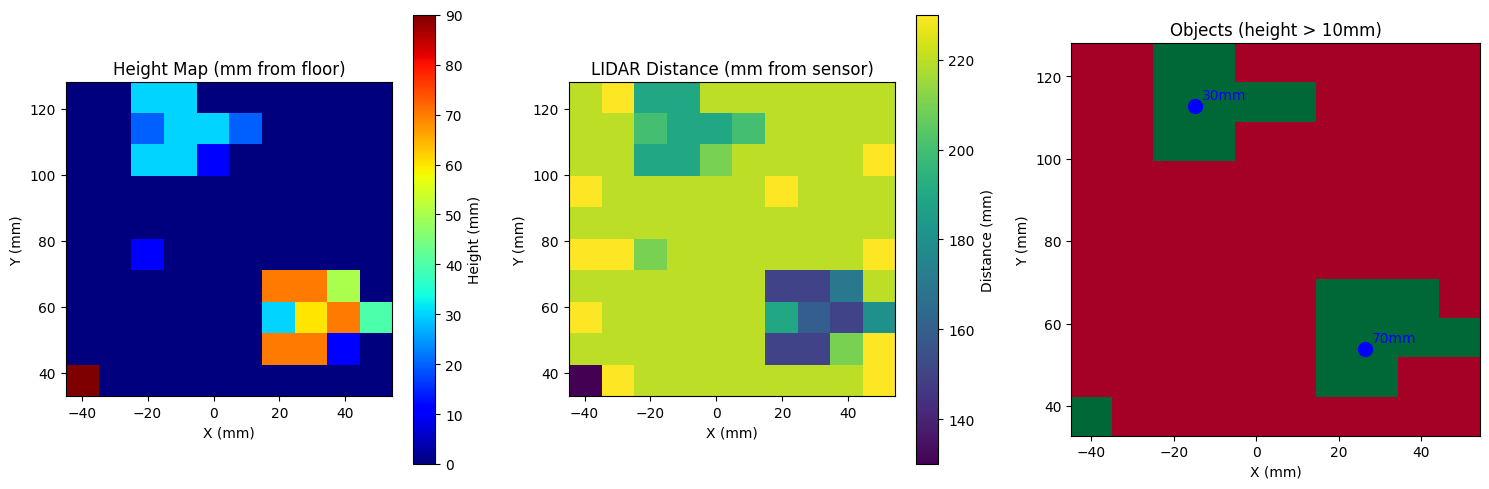

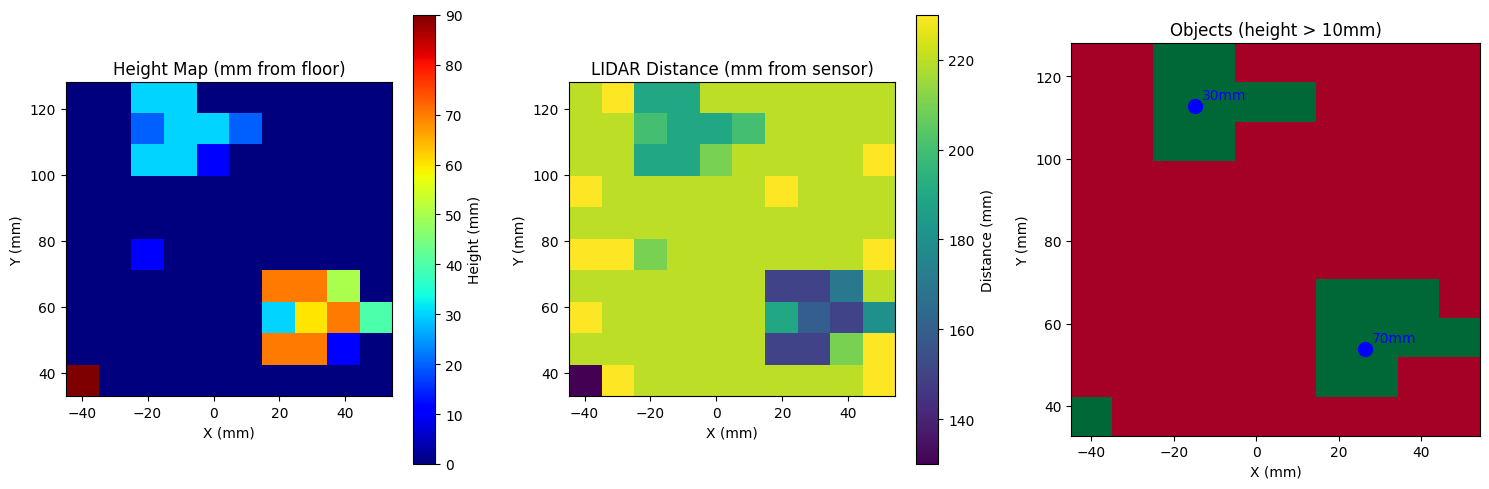

In [65]:
# Visualize the map
mapper.visualize(show_objects=True)

In [66]:
# Find objects from map
objects = mapper.find_objects(min_area=2)

# Select object to pick
if objects:
    print("\n📦 Objects available:")
    for i, obj in enumerate(objects):
        print(f"   [{i}] X={obj['center_x']:.0f} Y={obj['center_y']:.0f} H={obj['height']:.0f}mm")


🎯 Found 2 objects:
   Object 2: (26, 54) H=70mm
   Object 3: (-15, 113) H=30mm

📦 Objects available:
   [0] X=26 Y=54 H=70mm
   [1] X=-15 Y=113 H=30mm


In [67]:
# Camera + Height Map Overlay Visualization
import cv2
import numpy as np

cap = cv2.VideoCapture(CAMERA_ID)

print("="*60)
print("🎨 CAMERA + HEIGHT MAP OVERLAY")
print("   Click to see height at position")
print("   Press Q to close")
print("="*60)

# Store click position
click_pos = None

def on_click(event, x, y, flags, param):
    global click_pos
    if event == cv2.EVENT_LBUTTONDOWN:
        click_pos = (x, y)
        # Convert pixel to robot coordinates
        rx, ry = robot.pixel_to_robot(x, y)
        height = mapper.get_height_at(rx, ry)
        if height is not None:
            print(f"📍 Pixel({x},{y}) → Robot({rx:.0f},{ry:.0f}) → Height: {height}mm")
        else:
            print(f"📍 Pixel({x},{y}) → Robot({rx:.0f},{ry:.0f}) → Outside scan area")

cv2.namedWindow('Camera + HeightMap')
cv2.setMouseCallback('Camera + HeightMap', on_click)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    
    display = frame.copy()
    
    # Overlay height map if available
    if mapper.height_map is not None:
        # Create overlay from height map
        h, w = frame.shape[:2]
        
        # Draw scan area rectangle
        p1 = robot.pixel_to_robot(0, 0)  # Not exact, just for demo
        
        # Draw detected objects on camera
        objects = mapper.find_objects(min_area=2) if hasattr(mapper, 'height_map') else []
        
        for obj in objects:
            # Convert robot coords back to pixel (approximate)
            # This requires inverse homography
            rx, ry = obj['center_x'], obj['center_y']
            
            # Use homography inverse
            H_inv = np.linalg.inv(robot.H)
            pt = np.array([rx, ry, 1], dtype=np.float32)
            res = np.dot(H_inv, pt)
            px, py = int(res[0]/res[2]), int(res[1]/res[2])
            
            # Draw circle at object position
            cv2.circle(display, (px, py), 20, (0, 0, 255), 2)
            cv2.putText(display, f"{obj['height']:.0f}mm", (px+25, py),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    
    # Draw click position
    if click_pos:
        cv2.circle(display, click_pos, 5, (0, 255, 0), -1)
    
    # Info bar
    cv2.rectangle(display, (0, 0), (640, 40), (30, 30, 30), -1)
    obj_count = len(objects) if mapper.height_map is not None else 0
    cv2.putText(display, f"Objects: {obj_count} | Click to check height | Q=Quit",
               (10, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    cv2.imshow('Camera + HeightMap', display)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

🎨 CAMERA + HEIGHT MAP OVERLAY
   Click to see height at position
   Press Q to close

🎯 Found 2 objects:
   Object 2: (26, 54) H=70mm
   Object 3: (-15, 113) H=30mm

🎯 Found 2 objects:
   Object 2: (26, 54) H=70mm
   Object 3: (-15, 113) H=30mm

🎯 Found 2 objects:
   Object 2: (26, 54) H=70mm
   Object 3: (-15, 113) H=30mm

🎯 Found 2 objects:
   Object 2: (26, 54) H=70mm
   Object 3: (-15, 113) H=30mm

🎯 Found 2 objects:
   Object 2: (26, 54) H=70mm
   Object 3: (-15, 113) H=30mm

🎯 Found 2 objects:
   Object 2: (26, 54) H=70mm
   Object 3: (-15, 113) H=30mm

🎯 Found 2 objects:
   Object 2: (26, 54) H=70mm
   Object 3: (-15, 113) H=30mm

🎯 Found 2 objects:
   Object 2: (26, 54) H=70mm
   Object 3: (-15, 113) H=30mm

🎯 Found 2 objects:
   Object 2: (26, 54) H=70mm
   Object 3: (-15, 113) H=30mm

🎯 Found 2 objects:
   Object 2: (26, 54) H=70mm
   Object 3: (-15, 113) H=30mm

🎯 Found 2 objects:
   Object 2: (26, 54) H=70mm
   Object 3: (-15, 113) H=30mm

🎯 Found 2 objects:
   Object 2: (2

---
# 🎯 PICK FROM MAP
---

In [68]:
def pick_from_map(obj, grip_width=30):
    """Pick object using height from map"""
    x = obj['center_x']
    y = obj['center_y']
    height = obj['height']
    
    # Calculate Z_GRASP from map height
    z_grasp = Z_FLOOR + height - 5  # 5mm below top
    z_grasp = max(Z_FLOOR, z_grasp)
    
    print(f"\n🤖 Pick from Map:")
    print(f"   Position: ({x:.0f}, {y:.0f})")
    print(f"   Height: {height:.0f}mm → Z_GRASP={z_grasp:.1f}")
    
    # 1. Safe position
    robot.joint_move_and_wait(0, 0, 0, 0, 3)
    
    # 2. Open gripper
    gripper.open_fully()
    time.sleep(2)
    
    # 3. Move above object
    robot.move_to_and_wait(x, y, Z_SCAN, ROBOT_R_OFFSET, 2)
    
    # 4. Go down
    robot.move_to_and_wait(x, y, z_grasp, ROBOT_R_OFFSET, 2)
    
    # 5. Grip
    gripper.grip_object(grip_width)
    time.sleep(3)
    
    # 6. Lift
    robot.move_to_and_wait(x, y, z_grasp + 30, ROBOT_R_OFFSET, 2)
    
    # 7. Go to drop
    robot.move_to_and_wait(*DROP_POS[:3], DROP_POS[3], 3)
    
    # 8. Release
    gripper.release()
    time.sleep(2)
    
    # 9. Safe return
    robot.move_to_and_wait(DROP_POS[0], DROP_POS[1], 150, DROP_POS[3], 2)
    robot.joint_move_and_wait(0, 0, 0, 0, 3)
    robot.home()
    
    print("✅ Complete!")

In [70]:
# Pick first object from map
if objects:
    obj_index = 1  # Change this to pick different object
    print(f"Picking object {obj_index}...")
    pick_from_map(objects[obj_index], grip_width=30)
else:
    print("No objects found!")

Picking object 1...

🤖 Pick from Map:
   Position: (-15, 113)
   Height: 30mm → Z_GRASP=-39.0
🤖 HOME...
✅ Complete!


---
# 📏 UTILITIES
---

In [ ]:
# Check height at specific position
test_x = 350
test_y = 125
height = mapper.get_height_at(test_x, test_y)
print(f"Height at ({test_x}, {test_y}): {height}mm")

In [ ]:
# Save map data
np.save('height_map.npy', mapper.height_map)
np.save('distance_map.npy', mapper.distance_map)
print("Saved height_map.npy and distance_map.npy")

In [ ]:
# Load saved map
mapper.height_map = np.load('height_map.npy')
mapper.distance_map = np.load('distance_map.npy')
print("Loaded maps from file")
mapper.visualize()